## Data Visulization

##### Imoport the require package

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month
from os.path import abspath
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
from utils.Constants import Constants

In [5]:
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

table_path = "spark-warehouse/mydb.db/weather_data_partitioned_by_month"
df = spark.read.format("parquet").load(table_path)
df.show(5)



24/12/07 21:49:24 WARN Utils: Your hostname, acer resolves to a loopback address: 127.0.1.1; using 192.168.0.110 instead (on interface wlp0s20f3)
24/12/07 21:49:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 21:49:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+----------+
|      date|    time|water_content(m3/m3)|solar_radiation(w/m2)|rain(mm)|temperature(celcius)|rh(%)|wind_speed(m/s)|gust_speed(m/s)|wind_direction(degree)|dew_point(celcius)|year_month|
+----------+--------+--------------------+---------------------+--------+--------------------+-----+---------------+---------------+----------------------+------------------+----------+
|2021-01-01|15:35:00|              0.3393|                221.0|     0.0|               26.57| 60.9|            1.7|            4.0|                 331.0|             18.43|    2021-1|
|2021-01-01|01:25:00|              0.3371|                  1.0|     0.0|               23.45| 63.4|            1.3|            3.7|                  21.0|             16.12|    2021-1|
|2021-01-01|02:50:00|              0.3371|                  1.0|     0

24/12/07 21:49:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [8]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- water_content(m3/m3): float (nullable = true)
 |-- solar_radiation(w/m2): float (nullable = true)
 |-- rain(mm): float (nullable = true)
 |-- temperature(celcius): float (nullable = true)
 |-- rh(%): float (nullable = true)
 |-- wind_speed(m/s): float (nullable = true)
 |-- gust_speed(m/s): float (nullable = true)
 |-- wind_direction(degree): float (nullable = true)
 |-- dew_point(celcius): float (nullable = true)
 |-- year_month: string (nullable = true)



In [6]:
from pyspark.sql.functions import when, col

# Add a new column 'shift' based on the condition
solar_tem = df.select('solar_radiation(w/m2)', 'temperature(celcius)').withColumn(
    'shift', 
    when(df['solar_radiation(w/m2)'] == 1, "Night").otherwise("Day")
)

# Show rows where temperature is greater than 50
solar_tem.filter(col("temperature(celcius)") > 50).show()


+---------------------+--------------------+-----+
|solar_radiation(w/m2)|temperature(celcius)|shift|
+---------------------+--------------------+-----+
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                399.0|              537.33|  Day|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                  1.0|              537.33|Night|
|                 79.0|              537.33|  Day|
|                  1.0|              537.33|Night|
|                  1.0|        

In [7]:
from pyspark.sql import functions as F

# Calculate Q1, Q3 and IQR
quantiles = solar_tem.approxQuantile("temperature(celcius)", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers
cleaned_data = solar_tem.filter((col("temperature(celcius)") >= lower_bound) & 
                                (col("temperature(celcius)") <= upper_bound))

# Show cleaned data (without outliers)
cleaned_data.show()
cleaned_data.filter(col("temperature(celcius)") > 50).show()
cleaned_data.count()

+---------------------+--------------------+-----+
|solar_radiation(w/m2)|temperature(celcius)|shift|
+---------------------+--------------------+-----+
|                221.0|               26.57|  Day|
|                  1.0|               23.45|Night|
|                  1.0|                22.8|Night|
|                 89.0|               21.96|  Day|
|                759.0|               26.16|  Day|
|                553.0|               26.87|  Day|
|                401.0|               27.21|  Day|
|                 77.0|                26.6|  Day|
|                  1.0|                22.3|Night|
|                302.0|               23.52|  Day|
|                262.0|               26.35|  Day|
|                  1.0|               25.82|Night|
|                383.0|               23.62|  Day|
|                434.0|                27.9|  Day|
|                  1.0|               23.81|Night|
|                 29.0|               21.58|  Day|
|                321.0|        

134194

/tmp/ipykernel_32653/3324463716.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(
/tmp/ipykernel_32653/3324463716.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(


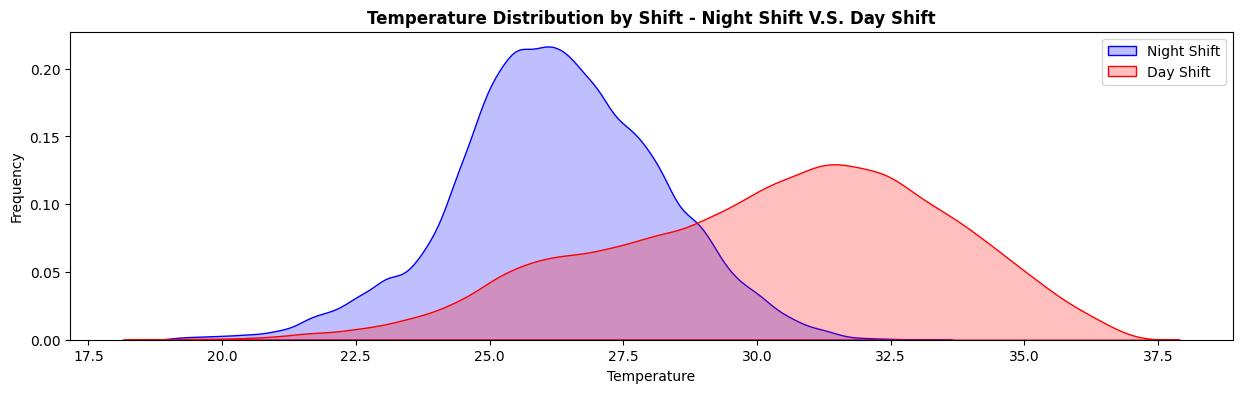

In [6]:
# Assuming solar_tem is a PySpark DataFrame
solar_tem_pd = cleaned_data.toPandas()  # Convert to pandas DataFrame

# KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15, 4))
ax = sns.kdeplot(
    solar_tem_pd.loc[solar_tem_pd['shift'] == "Night", 'temperature(celcius)'],
    color='b',
    shade=True,
    label='Night Shift'
)
ax = sns.kdeplot(
    solar_tem_pd.loc[solar_tem_pd['shift'] == "Day", 'temperature(celcius)'],
    color='r',
    shade=True,
    label='Day Shift'
)
ax.set(xlabel='Temperature', ylabel='Frequency')
plt.legend()
plt.title('Temperature Distribution by Shift - Night Shift V.S. Day Shift', fontweight='bold')
plt.show()
